In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

## Import module

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import os
import sys
from torchsummary import summary
from torchvision import transforms                                                                                                                                        
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import accuracy_score
mpl.rcParams['figure.dpi'] = 600
from PIL import Image
import pickle

import sys
sys.path.append("../../../src/")
sys.path.append("../..")
import model
from datasets import imagenet
import config
from aux.utils import obtain_features_map, load_imgs, zscore, extract_valid,\
     get_gt_pred_specific_class, get_differ
from aux.visualization import visualize_features_map, plot_differ
from utils.function import recreate_image                                                                                                                                       

from numpy import linalg as LA
import numpy as np

# Hyperparameter & Load model from Dict

In [3]:
resume = "037-0"
model_dir = "/home/lincolnzjx/Desktop/Interpretation/saved/models"
generated_dir = "/home/lincolnzjx/Desktop/saved/generated/"
backbone = "vgg16"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model
net = model.Network(backbone=backbone, num_classes=1000)
net.to(device)

# resume from model
resume_exp = resume.split("-")[0]
resume_epoch = resume.split("-")[1]
print("Resume from model from exp: {} at epoch {}".format(resume_exp, resume_epoch))
resume_path = os.path.join(model_dir, str(resume_exp), str(resume_epoch))
ckpt = torch.load(resume_path, map_location=device)
net.load_state_dict(ckpt) 

# Class & data
batch_size = 256
num_workers = 4
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
reverse_mean = [-0.485, -0.456, -0.406]
reverse_std = [1/0.229, 1/0.224, 1/0.225]

> Use original fc
Resume from model from exp: 037 at epoch 0


In [4]:
params = {}
conv_index = 1
linear_index = 1
for name, param in net.named_parameters():
    if "features" in name and "weight" in name: 
        conv_name = "conv-{}".format(conv_index)
        print(name, conv_name, param.size())
        conv_index = conv_index + 1
        params[conv_name] = param.detach().cpu()
    if not "features" in name and "weight" in name: 
        linear_name = "linear-{}".format(linear_index)
        print(name, linear_name, param.size())
        linear_index = linear_index + 1
        params[linear_name] = param.detach().cpu()

model.features.0.weight conv-1 torch.Size([64, 3, 3, 3])
model.features.2.weight conv-2 torch.Size([64, 64, 3, 3])
model.features.5.weight conv-3 torch.Size([128, 64, 3, 3])
model.features.7.weight conv-4 torch.Size([128, 128, 3, 3])
model.features.10.weight conv-5 torch.Size([256, 128, 3, 3])
model.features.12.weight conv-6 torch.Size([256, 256, 3, 3])
model.features.14.weight conv-7 torch.Size([256, 256, 3, 3])
model.features.17.weight conv-8 torch.Size([512, 256, 3, 3])
model.features.19.weight conv-9 torch.Size([512, 512, 3, 3])
model.features.21.weight conv-10 torch.Size([512, 512, 3, 3])
model.features.24.weight conv-11 torch.Size([512, 512, 3, 3])
model.features.26.weight conv-12 torch.Size([512, 512, 3, 3])
model.features.28.weight conv-13 torch.Size([512, 512, 3, 3])
model.fc.0.weight linear-1 torch.Size([4096, 25088])
model.fc.3.weight linear-2 torch.Size([4096, 4096])
model.fc.6.weight linear-3 torch.Size([1000, 4096])


In [5]:
def get_top_k(cov_matrix, filter_index, top_k=10, method="l1", descend=True):
    # if method in ["l1", "l2"]:
    if descend:
        index = np.argsort(cov_matrix, axis=1)[filter_index][1:top_k+1]
    else:
        index = np.argsort(cov_matrix, axis=1)[filter_index][-1:-(top_k+1):-1]
    distance = cov_matrix[filter_index][index]
    return index, distance
    # elif method == "cos":
    #     return np.argsort(cov_matrix, axis=1)[filter_index][1:top_k+1::-1]
    
def compute_norm(filters, norm=1):
    """Compute l1 norm. Smaller is better.
    Args: 
        filter: [output_channel, input_channel, height, width]
    """
    rows = cols = filters.shape[0]
    cov_matrix = np.zeros((rows, cols))
    for row in range(rows):
        for col in range(cols):
            if row == col:
                continue
            front = filters[row].reshape(-1)
            back = filters[col].reshape(-1)
            differ = front - back
            cov_matrix[row, col] = LA.norm(differ, ord=norm)
    return cov_matrix

def compute_cosine_similarity(filters):
    """Compute cosine similarity, but up move 1 and scale by multiplying 0.5 
        Smalller is better.
    Args: 
        filter: [output_channel, input_channel, height, width]
    """
    rows = cols = filters.shape[0]
    cov_matrix = np.zeros((rows, cols))
    for row in range(rows):
        for col in range(cols):
            if row == col:
                continue
            front = filters[row].reshape(-1)
            front_norm = front / LA.norm(front, ord=2)
            back = filters[col].reshape(-1)
            back_norm = back / LA.norm(back, ord=2)
            cos = np.dot(front_norm, back_norm)
            cos_modify = 0.5 + 0.5 * cos
            cov_matrix[row, col] = 1 - cos_modify
    return cov_matrix
    
    
def compute_similarity(filters, method="l1"):
    """Copute Similarity.
    Args:
        filter: [output_channel, input_channel, height, width]
    Returns:
        distance_matrix: [output_channel, output_channe]
    """
    if method == "l1":
        return compute_norm(filters, norm=1)
    elif method == "l2":
        return compute_norm(filters, norm=2)
    elif method == "cos":
        return compute_cosine_similarity(filters)
    else:
        print("Invalid distance measurement method.")
        sys.exit(-1)

In [6]:
def plot_cov_matrix(conv_filters, method="l1", title="cov matrix distance."):
    cov_matrix = compute_similarity(conv_filters, method=method)
    fig, ax = plt.subplots()
    cax = ax.matshow(cov_matrix)
    fig.colorbar(cax)
    ax.set_title(title +" via "+ method.upper(), pad=10)
    return cov_matrix

## Layer 1 distance matrix, Smaller is better

### L1F47

In [7]:
conv_filters = params["conv-1"]
filter_index = 47

Similar Index: [44 45 43  3 61  7 52 12 54 35],
Distance: [3.32401037 3.38167453 3.58635473 3.69860768 3.77490544 3.82576203
 3.93359232 3.95926523 4.28892469 4.29390478]
Not Similar Index: [57 19 55 53 34 58  1  0  6  2],
Distance: [11.06411552 11.03103256 10.45315647  9.98268032  9.53516006  9.52480221
  9.28588867  9.14348221  9.08316898  8.71571636]


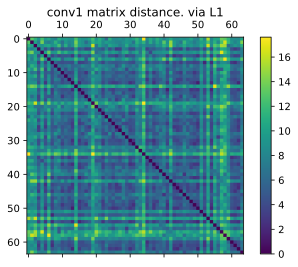

In [8]:
cov_matrix = plot_cov_matrix(conv_filters, method="l1", 
                              title="conv1 matrix distance.")
print("Similar Index: {},\nDistance: {}".format(
    *get_top_k(cov_matrix, 
               filter_index=filter_index, top_k=10, descend=True)))
print("Not Similar Index: {},\nDistance: {}".format(
    *get_top_k(cov_matrix, 
               filter_index=filter_index, top_k=10, descend=False)))

Similar Index: [45 44 43  3 61  7 54 35 52 26],
Distance: [0.8009674  0.90595847 0.91051614 0.9362579  0.9511025  1.01303518
 1.04368114 1.05082023 1.05733728 1.0718348 ]
Not Similar Index: [19 57 58 55 53 34  0  6 51  2],
Distance: [2.62543631 2.53746653 2.46030879 2.39251328 2.31970072 2.23968911
 2.21900773 2.18649936 2.16669464 2.12488699]


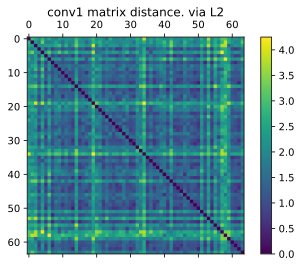

In [9]:
cov_matrix = plot_cov_matrix(conv_filters, method="l2", 
                              title="conv1 matrix distance.")
print("Similar Index: {},\nDistance: {}".format(
    *get_top_k(cov_matrix, 
               filter_index=filter_index, top_k=10, descend=True)))
print("Not Similar Index: {},\nDistance: {}".format(
    *get_top_k(cov_matrix, 
               filter_index=filter_index, top_k=10, descend=False)))

Similar Index: [45 32  8 34 18 44  3 43 63 27],
Distance: [0.24540824 0.28248098 0.28688213 0.2937694  0.3042594  0.31035119
 0.31859912 0.34024704 0.35990627 0.36657031]
Not Similar Index: [28 15 25 13 54 41 50 48 30 16],
Distance: [0.80888253 0.80069017 0.80039573 0.73569894 0.73114809 0.7254419
 0.71969077 0.68893519 0.68131272 0.66967982]


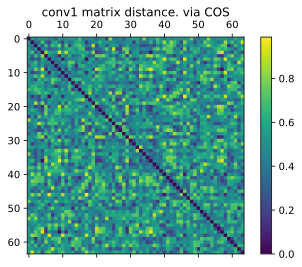

In [10]:
cov_matrix = plot_cov_matrix(conv_filters, method="cos", 
                              title="conv1 matrix distance.")
print("Similar Index: {},\nDistance: {}".format(
    *get_top_k(cov_matrix, 
               filter_index=filter_index, top_k=10, descend=True)))
print("Not Similar Index: {},\nDistance: {}".format(
    *get_top_k(cov_matrix, 
               filter_index=filter_index, top_k=10, descend=False)))

### L1F16

In [27]:
conv_filters = params["conv-1"]
filter_index = 16

Similar Index: [54  7 41 35 22 52 25 28 60 38],
Distance: [3.41705346 3.45016718 3.6388998  3.67528462 3.75318527 3.7819159
 3.91733074 3.94149542 4.00804043 4.12732029]
Not Similar Index: [34 14 53  6  4 57 58 55  0  2],
Distance: [11.57003593 10.36030293  9.95941067  9.93505669  9.77571869  9.51495838
  9.29408741  9.27673721  9.01162052  8.97228909]


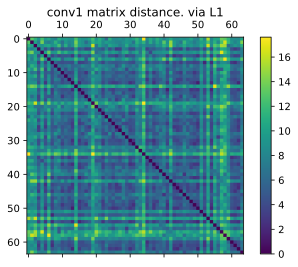

In [28]:
cov_matrix = plot_cov_matrix(conv_filters, method="l1", 
                              title="conv1 matrix distance.")
print("Similar Index: {},\nDistance: {}".format(
    *get_top_k(cov_matrix, 
               filter_index=filter_index, top_k=10, descend=True)))
print("Not Similar Index: {},\nDistance: {}".format(
    *get_top_k(cov_matrix, 
               filter_index=filter_index, top_k=10, descend=False)))

Similar Index: [ 7 35 54 41 25 61 48 52 28 22],
Distance: [0.8382923  0.88954461 0.93331212 0.9356426  0.94401866 0.9485631
 0.95273656 0.95357198 0.9572885  0.96358067]
Not Similar Index: [34 58 57  2  4 14  6 59 53 19],
Distance: [2.82333088 2.41155672 2.3870542  2.36857343 2.30100632 2.25288343
 2.23855615 2.23820853 2.22107601 2.20042062]


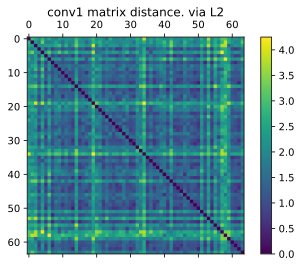

In [29]:
cov_matrix = plot_cov_matrix(conv_filters, method="l2", 
                              title="conv1 matrix distance.")
print("Similar Index: {},\nDistance: {}".format(
    *get_top_k(cov_matrix, 
               filter_index=filter_index, top_k=10, descend=True)))
print("Not Similar Index: {},\nDistance: {}".format(
    *get_top_k(cov_matrix, 
               filter_index=filter_index, top_k=10, descend=False)))

Similar Index: [28 38 48 25  7 35 22 19 41 40],
Distance: [0.20148736 0.31282622 0.32742904 0.32751554 0.3295691  0.366918
 0.37736603 0.40100871 0.40677028 0.41663703]
Not Similar Index: [26 24 18 27 43 44 62  3 13 50],
Distance: [0.85403168 0.84725428 0.83997005 0.79808605 0.78760797 0.78724679
 0.78000981 0.72496469 0.70811003 0.69541812]


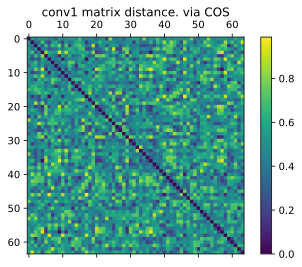

In [30]:
cov_matrix = plot_cov_matrix(conv_filters, method="cos", 
                              title="conv1 matrix distance.")
print("Similar Index: {},\nDistance: {}".format(
    *get_top_k(cov_matrix, 
               filter_index=filter_index, top_k=10, descend=True)))
print("Not Similar Index: {},\nDistance: {}".format(
    *get_top_k(cov_matrix, 
               filter_index=filter_index, top_k=10, descend=False)))

## Layer 2 distance matrix, Smaller is better

(array([33,  6, 15, 22, 55, 43, 51, 58, 27, 23]), array([23.87965775, 24.47730637, 24.69231987, 25.10338593, 25.30436134,
       26.21553421, 26.31115723, 26.52131653, 27.0231266 , 27.07913589]))
(array([33,  6, 15, 55, 22, 43, 58, 51, 28, 27]), array([1.28442001, 1.30899453, 1.32211876, 1.35922611, 1.38462591,
       1.39640796, 1.42368293, 1.42793703, 1.4330548 , 1.44211686]))
(array([58,  6, 22, 48, 54, 43,  2, 63, 55, 50]), array([0.30308238, 0.32089077, 0.32344681, 0.32864843, 0.39217093,
       0.39405731, 0.40756187, 0.41097128, 0.41353306, 0.41932007]))


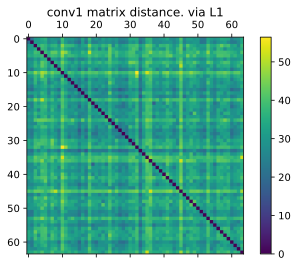

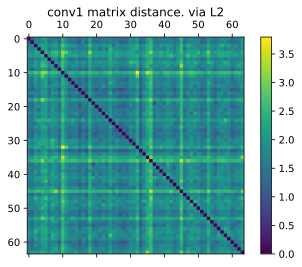

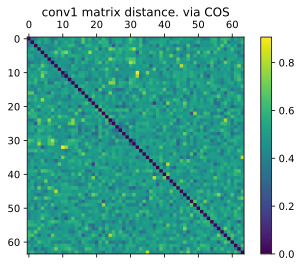

In [9]:
conv_filters = params["conv-2"]
filter_index = 16
cov_matrix = plot_cov_matrix(conv_filters, method="l1", 
                              title="conv1 matrix distance.")
print(get_top_k(cov_matrix, filter_index=filter_index, top_k=10))
cov_matrix = plot_cov_matrix(conv_filters, method="l2", 
                             title="conv1 matrix distance.")
print(get_top_k(cov_matrix, filter_index=filter_index, top_k=10))
cov_matrix = plot_cov_matrix(conv_filters, method="cos", 
                             title="conv1 matrix distance.")
print(get_top_k(cov_matrix, filter_index=filter_index, top_k=10))

# Bias

In [9]:
bias_params = {}
conv_index = 1
linear_index = 1
for name, param in net.named_parameters():
    if "features" in name and "bias" in name: 
        conv_name = "conv-{}".format(conv_index)
        print(name, conv_name, param.size())
        conv_index = conv_index + 1
        bias_params[conv_name] = param.detach().cpu()
    if not "features" in name and "bias" in name: 
        linear_name = "linear-{}".format(linear_index)
        print(name, linear_name, param.size())
        linear_index = linear_index + 1
        bias_params[linear_name] = param.detach().cpu()

model.features.0.bias conv-1 torch.Size([64])
model.features.2.bias conv-2 torch.Size([64])
model.features.5.bias conv-3 torch.Size([128])
model.features.7.bias conv-4 torch.Size([128])
model.features.10.bias conv-5 torch.Size([256])
model.features.12.bias conv-6 torch.Size([256])
model.features.14.bias conv-7 torch.Size([256])
model.features.17.bias conv-8 torch.Size([512])
model.features.19.bias conv-9 torch.Size([512])
model.features.21.bias conv-10 torch.Size([512])
model.features.24.bias conv-11 torch.Size([512])
model.features.26.bias conv-12 torch.Size([512])
model.features.28.bias conv-13 torch.Size([512])
model.fc.0.bias linear-1 torch.Size([4096])
model.fc.3.bias linear-2 torch.Size([4096])
model.fc.6.bias linear-3 torch.Size([1000])


# conv weight

In [12]:
def print_filter_avg_channel(params, bias_params, layer_name, conv_index):
    print("="*20, "{}-{}".format(layer_name, conv_index), "="*20)
    print(params[layer_name][conv_index].size())
    print("Red", torch.sum(params[layer_name][conv_index][0]))
    print("Green", torch.sum(params[layer_name][conv_index][1]))
    print("Blue", torch.sum(params[layer_name][conv_index][2])) 
    # Bias
    print("Bias", bias_params[layer_name][conv_index])
    # Sum up
    sum_weight = torch.sum(params[layer_name][conv_index])
    print("Sum of weights", sum_weight) 
    return sum_weight

In [13]:
# Conv-1
for index in range(64):
    layer_name = "conv-1"
    print_filter_avg_channel(params, bias_params, layer_name, index)

==================== conv-1-0 ====================
torch.Size([3, 3, 3])
Red tensor(0.4029)
Green tensor(-0.3553)
Blue tensor(-0.0011)
Bias tensor(0.4034)
Sum of weights tensor(0.0465)
==================== conv-1-1 ====================
torch.Size([3, 3, 3])
Red tensor(0.0056)
Green tensor(-0.0219)
Blue tensor(0.0407)
Bias tensor(0.3778)
Sum of weights tensor(0.0244)
==================== conv-1-2 ====================
torch.Size([3, 3, 3])
Red tensor(0.0705)
Green tensor(-0.0412)
Blue tensor(-0.0339)
Bias tensor(0.4644)
Sum of weights tensor(-0.0045)
==================== conv-1-3 ====================
torch.Size([3, 3, 3])
Red tensor(0.8916)
Green tensor(-0.8623)
Blue tensor(0.5108)
Bias tensor(-0.3228)
Sum of weights tensor(0.5401)
==================== conv-1-4 ====================
torch.Size([3, 3, 3])
Red tensor(-0.0270)
Green tensor(0.0015)
Blue tensor(0.0312)
Bias tensor(0.3940)
Sum of weights tensor(0.0057)
==================== conv-1-5 ====================
torch.Size([3, 3, 3])
Red

Red tensor(-0.3552)
Green tensor(-1.2925)
Blue tensor(0.5676)
Bias tensor(-1.0248)
Sum of weights tensor(-1.0802)
==================== conv-1-45 ====================
torch.Size([3, 3, 3])
Red tensor(0.7308)
Green tensor(-0.9100)
Blue tensor(-0.4111)
Bias tensor(-0.6912)
Sum of weights tensor(-0.5903)
==================== conv-1-46 ====================
torch.Size([3, 3, 3])
Red tensor(-0.0411)
Green tensor(0.0329)
Blue tensor(-0.0329)
Bias tensor(-0.7711)
Sum of weights tensor(-0.0412)
==================== conv-1-47 ====================
torch.Size([3, 3, 3])
Red tensor(1.2419)
Green tensor(-1.0355)
Blue tensor(-0.1974)
Bias tensor(0.2612)
Sum of weights tensor(0.0090)
==================== conv-1-48 ====================
torch.Size([3, 3, 3])
Red tensor(-0.8166)
Green tensor(1.2200)
Blue tensor(-0.4634)
Bias tensor(0.4033)
Sum of weights tensor(-0.0600)
==================== conv-1-49 ====================
torch.Size([3, 3, 3])
Red tensor(-0.5926)
Green tensor(0.7261)
Blue tensor(-0.2235)
B

In [15]:
# Conv-3
# for index in range(64):
#     layer_name = "conv-3"
#     print_filter_avg_channel(params, bias_params, layer_name, index)